In [1]:
import torch
from IPython.display import clear_output
import numpy as np
from PIL import Image
from owl_dreamsim_utils import eval_with_dreamsim, eval_with_dinov2

cache_dir = 'models'

evalulator = eval_with_dreamsim(cache_dir=cache_dir, device='cuda')
# evalulator = eval_with_dinov2(cache_dir=None, device='cuda')
clear_output()

In [2]:
# functions for D&C
def get_gt_matrix(query_dict):
    embs = query_dict['query_emb']
    n = len(embs)
    gt_matrix = torch.zeros(n, n)
    # Fill the matrix
    for i in range(n):
        for j in range(i, n):  # Only calculate for i <= j
            if i == j:
                # Diagonal: Mean of self-similarity
                similarity = (embs[i] / embs[i].norm(dim=-1, keepdim=True)).matmul((embs[i] / embs[i].norm(dim=-1, keepdim=True)).t())
                gt_matrix[i, j] = similarity.mean()
            else:
                # Off-diagonal: Mean of inter-group similarity
                inter_similarity = (embs[i] / embs[i].norm(dim=-1, keepdim=True)).matmul((embs[j] / embs[j].norm(dim=-1, keepdim=True)).t())
                mean_similarity = inter_similarity.mean()
                gt_matrix[i, j] = mean_similarity
                gt_matrix[j, i] = mean_similarity  # Assign to A[j, i] without recalculating
    gt_matrix = np.array(gt_matrix)
    return gt_matrix

def sort_by_max(A):
    sorted_rows = np.zeros_like(A)
    used_rows = []

    # Iterate over each column
    for i in range(A.shape[1]):
        # Find the maximum value in the i-th column that hasn't been used yet
        max_value = -np.inf
        max_index = -1
        for j in range(A.shape[0]):
            if j not in used_rows and A[j, i] > max_value:
                max_value = A[j, i]
                max_index = j

        # Add the row with the maximum value to the sorted array
        sorted_rows[i] = A[max_index]
        used_rows.append(max_index)
    return sorted_rows

def gt_distance(scores, gt_matrix, ord=None):
    if len(scores) != len(gt_matrix):
        print(f'Count:{len(scores)}')
        return 1.
    # scores = [x.mean(-1).tolist() for x in np.array(scores)] # 2x2
    # scores = np.array(scores).mean(-1)
    tmp = []
    for bbox_score in scores:
        per_bbox = []
        for ref in bbox_score:
            per_bbox.append(np.array(ref).mean())
        tmp.append(per_bbox)
    
    # scores = [np.array(x).mean(-1) for x in scores]
    scores = np.array(tmp)
    scores = sort_by_max(scores)
    return np.linalg.norm(scores - gt_matrix, ord=ord)

In [3]:
query_dict = {
    'query_name': ["monster toy", "robot toy"],
    'query_path': ["examples/references/monster_toy",
                    "examples/references/robot_toy"]
}

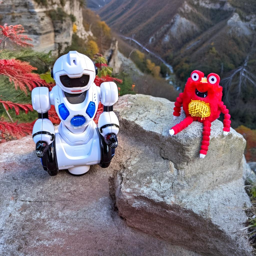

GT score: 0.93


In [4]:
image = "examples/images/good.jpg"
image = Image.open(image)
scores = evalulator.score(image, query_dict, threshold=0.4, return_round=False)

gt_matrix = get_gt_matrix(query_dict)
image.resize((256, 256)).show()
print(f"GT score: {1 - gt_distance(scores, gt_matrix, ord=2):.2f}")

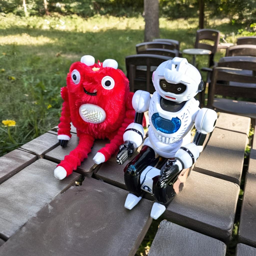

GT score: 0.85


In [5]:
image = "examples/images/mixed1.jpg"
image = Image.open(image)
scores = evalulator.score(image, query_dict, threshold=0.4, return_round=False)

gt_matrix = get_gt_matrix(query_dict)
image.resize((256, 256)).show()
print(f"GT score: {1 - gt_distance(scores, gt_matrix, ord=2):.2f}")

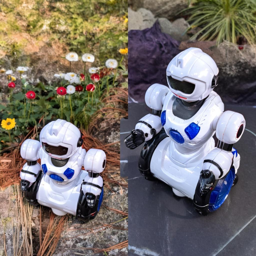

GT score: 0.28


In [6]:
image = "examples/images/single.jpg"
image = Image.open(image)
scores = evalulator.score(image, query_dict, threshold=0.4, return_round=False)

gt_matrix = get_gt_matrix(query_dict)
image.resize((256, 256)).show()
print(f"GT score: {1 - gt_distance(scores, gt_matrix, ord=2):.2f}")

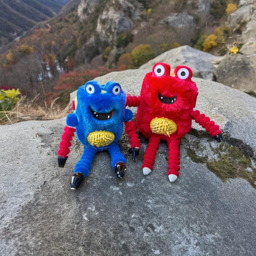

GT score: 0.55


In [7]:
image = "examples/images/mixed2.jpg"
image = Image.open(image)
scores = evalulator.score(image, query_dict, threshold=0.4, return_round=False)

gt_matrix = get_gt_matrix(query_dict)
image.resize((256, 256)).show()
print(f"GT score: {1 - gt_distance(scores, gt_matrix, ord=2):.2f}")

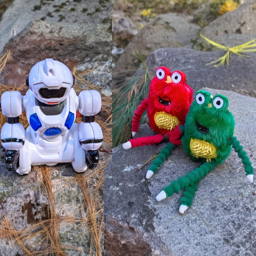

Count:3
GT score: 0.00


In [10]:
image = "examples/images/count.jpg"
image = Image.open(image)
scores = evalulator.score(image, query_dict, threshold=0.4, return_round=False)

gt_matrix = get_gt_matrix(query_dict)
image.resize((256, 256)).show()
print(f"GT score: {1 - gt_distance(scores, gt_matrix, ord=2):.2f}")